In [1]:
# Import the modified CSV file for better visualization.
# Note that the added sufixes (".1", ".2", ..., ".25") is added by pandas when read by doing df = pd.read_csv(csv_file).
# The actual CSV does not contain those sufixes.
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils import get_column_letter
from IPython.display import display, HTML
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LinearSegmentedColormap


DATA_DIR = Path.home() / "projects" / "data"

OUTPUT_DIR = Path.home() / "projects" / "mouse-DNA-project" / "results"

csv_file = DATA_DIR / "processed" / "GSE290585_SeSaMeBeta_MM285_BS_simplified_columns.csv" # path to mouse csv file

print(sys.executable)
print(csv_file.exists())

df = pd.read_csv(csv_file)

# -------------------------------- Filter df on NaN in the annotation csv file (originally from excel MM285) ----------------------------------------------
#Import Excel annotation file with metadata, identical probe_IDs as dataset -> we can filter on this and also map extracted regions back to the excel file.
annot_file = DATA_DIR / "original" / "12_02_2026_MM285.csv"
df_annot = pd.read_csv(annot_file, low_memory=False)

# drop any nan values from df_annot. We do not want to extract regions that contain no genomic information in the annotation file.
df_annot = df_annot.dropna(subset=["CpG_chrm"]).copy()

# make sure probe_id columns are strings
df["probe_ID"] = df["probe_ID"].astype(str)
df_annot["Probe_ID"] = df_annot["Probe_ID"].astype(str)

# create set of valid ids, for efficiency
valid_ids = set(df_annot["Probe_ID"])

# create mask based on valid_ids, and filter df using this mask + make it as independent dataframe by using copy (instead of accidentally creating a .view)
df = df[df["probe_ID"].isin(valid_ids)].copy() # Removing 7,415 rows, 296,070 rows -> 288,655 rows

print("Shape of df after NaN row filtering", df.shape)

# # Check probe_ID overlap between df (data) and df_annot (metadata) - There is 100% overlap of probe_IDs!!!
# ids_df = set(df["probe_ID"])
# ids_annot = set(df_annot["Probe_ID"])

# print("df only (missing in annotation):", len(ids_df - ids_annot))
# print("annotation only (missing in df):", len(ids_annot - ids_df))

# print("length of ids_df:", len(ids_df))
# print("length of annot_df:", len(ids_annot))


# print("Exact match:", ids_df == ids_annot)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------

with pd.option_context("display.max_columns", None,
                       "display.width", None):
        display(df.head(20))

# --- Colormap used in plots ---
blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow",
    ["#0000FF", "#ffff00"]
    )

# count how many cell type duplicates
# cell_type_counts = df.columns[1:].str.split(".", n=1).str[0].value_counts()
# print(cell_type_counts)





/home/jullid/projects/mouse-DNA-project/.venv/bin/python
True
Shape of df after NaN row filtering (288655, 268)


probe_ID  Adrenal  Adrenal.1  Adrenal.2  Adrenal.3  Adrenal.4  \
0   cg00101675_BC21    0.694      0.782      0.593      0.525      0.609   
1   cg00116289_BC21    0.685      0.786      0.653      0.611      0.630   
2   cg00211372_TC21    0.604      0.816      0.636      0.624      0.708   
3   cg00531009_BC21    0.770      0.825      0.752      0.752      0.768   
4   cg00747726_TC21    0.713      0.804      0.683      0.730      0.670   
5   cg00896209_TC21    0.739      0.839      0.789      0.756      0.759   
6   cg00910419_BC21    0.044      0.050      0.051      0.045      0.041   
7   cg00920372_BC21    0.469      0.524      0.485      0.476      0.386   
8   cg01326836_BC21    0.081      0.100      0.061      0.054      0.069   
9   cg01340195_BC21    0.673      0.771      0.653      0.614      0.647   
10  cg01603043_TC21    0.723      0.790      0.662      0.729      0.682   
11  cg01613817_BC11    0.562      0.503      0.609      0.623      0.606   
12  cg01683044_BC21    0.052      0.057      0.056      0.071      0.044   
13  cg02153806_BC21    0.205      0.207      0.235      0.211      0.227   
14  cg02176373_BC21    0.134      0.196      0.072      0.061      0.062   
15  cg02187860_TC21    0.687      0.783      0.684      0.697      0.711   
16  cg02245762_BC11    0.260      0.225      0.262      0.351      0.284   
17  cg02258130_TC21    0.725      0.805      0.502      0.587      0.644   
18  cg02380775_BC21    0.309      0.464      0.313      0.319      0.320   
19  cg02529685_TC11    0.957      0.944      0.932      0.927      0.930   

    Adrenal.5  Bile_Duct  Bile_Duct.1  Bile_Duct.2  Bile_Duct.3  Bile_Duct.4  \
0       0.626      0.631        0.600        0.600        0.602        0.581   
1       0.689      0.706        0.640        0.683        0.679        0.597   
2       0.695      0.821        0.609        0.658        0.731        0.716   
3       0.781      0.771        0.739        0.798        0.766        0.762   
4       0.726      0.751        0.727        0.717        0.782        0.769   
5       0.788      0.771        0.736        0.749        0.789        0.724   
6       0.059      0.036        0.034        0.062        0.054        0.074   
7       0.481      0.298        0.251        0.282        0.277        0.259   
8       0.066      0.087        0.073        0.098        0.098        0.091   
9       0.638      0.655        0.588        0.622        0.656        0.574   
10      0.671      0.561        0.507        0.565        0.594        0.538   
11      0.556      0.541        0.550        0.562        0.482        0.579   
12      0.057      0.047        0.040        0.072        0.055        0.038   
13      0.236      0.197        0.201        0.233        0.201        0.214   
14      0.072      0.138        0.056        0.102        0.053        0.055   
15      0.726      0.749        0.692        0.740        0.767        0.739   
16      0.240      0.238        0.266        0.325        0.286        0.313   
17      0.689      0.453        0.401        0.429        0.517        0.437   
18      0.376      0.688        0.653        0.718        0.700        0.648   
19      0.921      0.958        0.945        0.935        0.928        0.929   

    Bile_Duct.5  Blood  Blood.1  Blood.2  Blood.3  Blood.4  Blood.5  Blood.6  \
0         0.573  0.783    0.793    0.827    0.808    0.784    0.861    0.792   
1         0.631  0.795    0.766    0.841    0.722    0.756    0.842    0.795   
2         0.603  0.770    0.754    0.778    0.678    0.689    0.783    0.738   
3         0.765  0.763    0.795    0.807    0.789    0.798    0.864    0.812   
4         0.748  0.781    0.808    0.829    0.782    0.753    0.832    0.800   
5         0.771  0.825    0.817    0.840    0.835    0.822    0.865    0.860   
6         0.036  0.043    0.053    0.067    0.039    0.046    0.043    0.044   
7         0.289  0.443    0.458    0.421    0.384    0.385    0.465    0.427   
8         0.0

In [3]:
# Collapse cell type columns into one averaged column per cell type, resulting in 29 averaged cell types/columns

probe_ids = df["probe_ID"]
df_drop_ID = df.drop(columns="probe_ID")

df_drop_ID.shape

# remove suffix .1 .2 etc. added by pandas
cell_type_labels = df_drop_ID.columns.str.split(".", n=1).str[0]

# collapse replicates
# df_celltype = df_drop_ID.groupby(cell_type_labels, axis=1).mean()
df_celltype = df_drop_ID.T.groupby(cell_type_labels).mean().T

df_celltype.shape

# Reattach probe_ID
df_celltype.insert(0, "probe_ID", probe_ids)

with pd.option_context("display.max_columns", None,
                       "display.width", None):
        display(df_celltype.head(20))

df_celltype.shape

probe_ID   Adrenal  Bile_Duct     Blood  Brain_Cortex  Cerebellum  \
0   cg00101675_BC21  0.638167   0.597833  0.813083      0.794438    0.859667   
1   cg00116289_BC21  0.675667   0.656000  0.788250      0.708063    0.679778   
2   cg00211372_TC21  0.680500   0.689667  0.748083      0.750812    0.753444   
3   cg00531009_BC21  0.774667   0.766833  0.805000      0.694625    0.742444   
4   cg00747726_TC21  0.721000   0.749000  0.802583      0.804250    0.784556   
5   cg00896209_TC21  0.778333   0.756667  0.845167      0.819500    0.804778   
6   cg00910419_BC21  0.048333   0.049333  0.046000      0.047375    0.041333   
7   cg00920372_BC21  0.470167   0.276000  0.439667      0.400500    0.202333   
8   cg01326836_BC21  0.071833   0.088000  0.134500      0.088750    0.061556   
9   cg01340195_BC21  0.666000   0.613500  0.807583      0.560000    0.347667   
10  cg01603043_TC21  0.709500   0.549167  0.828583      0.307438    0.328111   
11  cg01613817_BC11  0.576500   0.540667  0.194500      0.687625    0.810667   
12  cg01683044_BC21  0.056167   0.048833  0.056083      0.045125    0.045000   
13  cg02153806_BC21  0.220167   0.210167  0.201917      0.153688    0.131889   
14  cg02176373_BC21  0.099500   0.075833  0.114083      0.137187    0.114556   
15  cg02187860_TC21  0.714667   0.740000  0.861833      0.802000    0.639222   
16  cg02245762_BC11  0.270333   0.284000  0.124500      0.261062    0.612222   
17  cg02258130_TC21  0.658667   0.451333  0.800667      0.578438    0.697222   
18  cg02380775_BC21  0.350167   0.682833  0.821083      0.589938    0.713444   
19  cg02529685_TC11  0.935167   0.941500  0.952917      0.960687    0.962111   

       Colon  Diaphragm      Ears     Eye   Femur   Heart    Kidney     Liver  \
0   0.686273   0.684500  0.625375  0.8333  0.6277  0.7001  0.656667  0.711577   
1   0.675455   0.684500  0.546375  0.7374  0.7029  0.7649  0.685167  0.776077   
2   0.638182   0.687667  0.640250  0.7652  0.7370  0.7337  0.685250  0.751577   
3   0.726727   0.746000  0.734000  0.8349  0.7690  0.8165  0.747000  0.773192   
4   0.617182   0.726333  0.689000  0.6762  0.7327  0.7725  0.764000  0.821000   
5   0.721545   0.761833  0.754000  0.8415  0.7964  0.8001  0.765917  0.786654   
6   0.038727   0.050667  0.046125  0.0428  0.0555  0.0509  0.044583  0.053115   
7   0.211273   0.334667  0.201500  0.3536  0.4066  0.3756  0.357667  0.573500   
8   0.063545   0.089667  0.081500  0.0771  0.1446  0.0938  0.075000  0.109962   
9   0.582364   0.561500  0.579000  0.2815  0.6983  0.7397  0.479167  0.747846   
10  0.572000   0.513167  0.320750  0.2118  0.6864  0.7402  0.460500  0.658885   
11  0.556455   0.453833  0.645625  0.7651  0.2141  0.4220  0.445917  0.539923   
12  0.041545   0.084833  0.050250  0.0537  0.0565  0.0533  0.047583  0.054769   
13  0.172636   0.182333  0.421000  0.2024  0.3094  0.2174  0.172500  0.162038   
14  0.057455   0.069500  0.078875  0.1677  0.1124  0.1410  0.071667  0.061577   
15  0.700545   0.558667  0.644250  0.4611  0.7644  0.8466  0.711000  0.825385   
16  0.269818   0.341000  0.310000  0.6496  0.1184  0.3204  0.447167  0.176462   
17  0.609909   0.670500  0.696250  0.7639  0.7049  0.6807  0.710833  0.279692   
18  0.656273   0.683333  0.648500  0.7398  0.7441  0.7336  0.658833  0.760654   
19  0.925545   0.879833  0.835875  0.9295  0.8582  0.9314  0.944250  0.948615   

      Lung  Mammary_Glands  Optic_Nerve  Pancreas    Retina  Sciatic_Nerve  \
0   0.7428        0.739000     0.805000  0.701286  0.748857         0.6426   
1   0.7806        0.707833     0.734889  0.721286  0.664714         0.6144   
2   0.7590        0.698667     0.730444  0.675714  0.685714         0.6150   
3   0.8016        0.786667     0.805111  0.767714  0.779143         0.7420   
4   0.7779        0.763167     0.847667  0.770714  0.571857         0.7148   
5   0.8093        0.800000     0.828889  0.763000  0.805429         0.7476   
6   0.0541        0.059333     0.041111  0.052571  0.052143         0.0462   
7   

(288655, 30)

In [3]:
def build_tissue_diff_table(
    df: pd.DataFrame,
    target_threshold: float = 0.7,
    background_threshold: float = 0.8,
    diff_threshold: float = 0.3,
    use_filtering: bool = False,
    id_col: str = "probe_ID",
) -> pd.DataFrame:
    """
    Build a long-format table of tissue-specific differential methylation scores.

    This function iterates over each tissue (column) in a tissue-averaged
    methylation matrix and, for every genomic region (row), computes:
      - target methylation (in the current tissue)
      - background methylation (mean across all other tissues)
      - a differential score (background − target)

    For each tissue, regions are ranked by the differential score, optionally
    applying simple biological filtering thresholds. Results from all tissues
    are stacked into a single DataFrame suitable for marker selection,
    downstream filtering, or heatmap construction.

    Parameters
    ----------
    df_celltype : pandas.DataFrame
        DataFrame with one row per genomic region and one column per tissue,
        plus an identifier column (default: "probe_ID").
    target_threshold : float, optional
        Threshold for low methylation in the target tissue (used only if
        filtering conditions are enabled).
    background_threshold : float, optional
        Threshold for high methylation in non-target tissues (used only if
        filtering conditions are enabled).
    diff_threshold : float, optional
        Minimum differential score (background − target), currently optional
        and commented out by default.
    use_filtering : bool, optional
        If False, all regions are ranked purely by differential score.
        If True, biological filtering is applied before ranking.
    id_col : str, optional
        Name of the region identifier column.

    Returns
    -------
    all_tissues_results : list of DataFrames.
    """
    # -------------------------------
    # config
    # -------------------------------

    TARGET_THRESHOLD = target_threshold
    BACKGROUND_THRESHOLD = background_threshold
    DIFF_THRESHOLD = diff_threshold

    # -------------------------------
    # setup
    # -------------------------------

    probe_ids = df[id_col]
    tissues = df.columns.drop(id_col)

    all_tissues_results = []  # we will stack results here

    # -------------------------------
    # loop over tissues
    # -------------------------------

    for tissue in tissues:

        # target methylation (per row/region)
        target = df[tissue]

        # background methylation (mean of all OTHER tissues, per row)
        background = (
            df
            .drop(columns=[id_col, tissue])
            .mean(axis=1)
        )

        # difference
        diff = background - target

        # assemble per-tissue df
        tissue_df = pd.DataFrame({
            id_col: probe_ids,
            "tissue": tissue,
            "target_meth": target,
            "background_meth": background,
            "diff": diff
        })

        # switch between pure sorting on diff (use_filtering == FALSE) and filtering + sorting on diff (use_filtering == TRUE)
        if use_filtering:
            tissue_df_sorted = (
                tissue_df[
                    # (tissue_df["target_meth"] < TARGET_THRESHOLD) &
                    (tissue_df["background_meth"] > BACKGROUND_THRESHOLD)
                    # (tissue_df["diff"] > DIFF_THRESHOLD)
                ]
                .sort_values(by="diff", ascending=False)
            )
        
        else:
            tissue_df_sorted = tissue_df.sort_values(
            by="diff",
            ascending=False
            )

        # store results
        all_tissues_results.append(tissue_df_sorted)

    return all_tissues_results

In [4]:
def combine_tissue_results(all_tissues_results, verbose=False):
    """
    Concatenate per-tissue result tables into a single DataFrame.
    """

    final_df = pd.concat(all_tissues_results, ignore_index=True)

    if verbose:
        print("Final shape:", final_df.shape)
        display(final_df.head())

    return final_df

In [5]:
def extract_top_regions(
    all_tissues_results: list,
    top_n: int = 25
) -> pd.DataFrame:
    """
    Extract the top N ranked regions per tissue from per-tissue result tables.

    Parameters
    ----------
    all_tissues_results : list of pandas.DataFrame
        List of per-tissue DataFrames, each sorted by differential score.
        Typically returned by build_tissue_diff_table().
    top_n : int
        Number of top regions to extract per tissue.

    Returns
    -------
    pandas.DataFrame
        Long-format DataFrame containing the top N regions per tissue.
    """

    top_regions_per_tissue = []

    for tissue_df in all_tissues_results:
        top_n_df = tissue_df.head(top_n)
        top_regions_per_tissue.append(top_n_df)

    df_top_regions = pd.concat(top_regions_per_tissue, ignore_index=True)

    # Sanity check
    print("Top regions shape:", df_top_regions.shape)

    return df_top_regions

In [6]:
#Do some statistics on this, such as median diff, mean diff, lowest/highest diff:
"""
Function that extracts some summary statistics for df_top_regions. Requires df_top_regions structure with columns = ["target_meth", "background_meth", "diff"].
"""
def stats_top_regions(df_top_regions):
    metrics_cols = ["target_meth", "background_meth", "diff"]
    df_metrics = df_top_regions[metrics_cols]

    summary_stats = df_metrics.describe().T
    summary_stats["range"] = summary_stats["max"] - summary_stats["min"]

    summary_stats = summary_stats.drop(columns=["count"]).T
    return summary_stats

Let:
m(r, t) = methylation of region r in tissue t
You want regions where, for a given tissue T:

Target is unmethylated
m(r, T) ≤ target_threshold


All other tissues are methylated
min(m(r, other tissues)) ≥ background_threshold

OR (slightly softer, more realistic):
second_lowest(m(r, all tissues)) ≥ background_threshold

In [7]:
def create_heatmap_matrix(df, df_top_regions, probe_col="probe_ID", region_mode="all", max_per_tissue=None, verbose=False):
    """
    Create a heatmap-ready matrix (tissues x regions).
    Parameters:
    -----------
    region_mode : str
        - "all": use all regions (including duplicates)
        - "unique": keep only regions selected exactly once
    max_per_tissue : int, optional
        Maximum number of regions to keep per tissue. Only works with region_mode="unique".
        Regions are kept in their original ranking order from df_top_regions.
    verbose : bool
        If True, print detailed information about region selection
    """
    if region_mode not in {"all", "unique"}:
        raise ValueError("region_mode must be 'all' or 'unique'")
    
    if max_per_tissue is not None and region_mode != "unique":
        raise ValueError("max_per_tissue can only be used with region_mode='unique'. To resolve, set max_per_tissue=None.\n"
                        "Note: Using region_mode='all' will always return the same amount of regions as defined in top_N since there is no uniqueness constraint filtering.")
    
    if region_mode == "all":
        region_order = df_top_regions[probe_col].tolist()
    else:  # unique
        probe_counts = df_top_regions[probe_col].value_counts()
        unique_probes = probe_counts[probe_counts == 1].index
        region_order = (
            df_top_regions[df_top_regions[probe_col].isin(unique_probes)]
            [probe_col]
            .tolist()
        )
    
    # Calculate counts before capping
    counts_before = (
        df_top_regions[df_top_regions[probe_col].isin(region_order)]
        ["tissue"]
        .value_counts()
        .rename("n_regions")
        .to_frame()
        .sort_index()
    )
    
    # Apply max_per_tissue cap if specified
    if max_per_tissue is not None:
        # Check for tissues below max_per_tissue threshold
        tissues_below_max = counts_before[counts_before["n_regions"] < max_per_tissue]
        if not tissues_below_max.empty:
            warning_msg = "Some tissues have fewer regions than max_per_tissue:\n"
            for tissue, row in tissues_below_max.iterrows():
                warning_msg += f"  - {tissue}: {row['n_regions']} regions\n"
            warnings.warn(warning_msg, UserWarning)
        
        # Filter to unique regions and apply cap while preserving order
        df_filtered = df_top_regions[df_top_regions[probe_col].isin(region_order)]
        
        # Group by tissue and take first max_per_tissue regions (preserves df_top_regions order)
        capped_regions = (
            df_filtered
            .groupby("tissue", sort=False)
            .head(max_per_tissue)
            [probe_col]
            .tolist()
        )
        region_order = capped_regions
    
    # Calculate final counts
    counts = (
        df_top_regions[df_top_regions[probe_col].isin(region_order)]
        ["tissue"]
        .value_counts()
        .rename("n_regions")
        .to_frame()
        .sort_index()
    )
    
    # Reorder counts to match heatmap x-axis order
    ordered_tissues = (
        df_top_regions
        .loc[df_top_regions[probe_col].isin(region_order), "tissue"]
        .drop_duplicates()
        .tolist()
    )
    counts = counts.loc[ordered_tissues]
    
    if verbose:
        print(f"Region mode: {region_mode}")
        
        if max_per_tissue is not None:
            print(f"\n--- BEFORE capping (max_per_tissue={max_per_tissue}) ---")
            print(f"Total regions: {len(counts_before)}")
            display(counts_before)
            
            print(f"\n--- AFTER capping ---")
            print(f"Total regions: {len(region_order)}")
            display(counts)
        else:
            print(f"Total regions used: {len(region_order)}")
            display(counts)
    
    heatmap_df = (
        df
        .set_index(probe_col)
        .loc[region_order]
    )
    
    return heatmap_df.T, counts

In [8]:
""" plot_heatmap function using regions_per_tissue_count (counts) and passing top_N explicitly"""

def plot_heatmap(heatmap_matrix, counts, top_n=None, title=None, figsize=(20, 8)):
    """
    Plot methylation heatmap with automatic tissue block labels.

    Parameters
    ----------
    heatmap_matrix : pd.DataFrame
        DataFrame of shape (tissues × regions)
    counts : pd.DataFrame
        DataFrame with index = tissue names (in plot order)
        and column 'n_regions' giving number of regions per tissue
    """

    # extract labels and block sizes from counts
    # counts is a df with index (cell type) and n_regions in each tissue
    tissue_labels = counts.index.tolist()
    block_sizes = counts["n_regions"].values

    # compute xtick positions (center of each tissue block)
    xtick_positions = []
    current_pos = 0

    for size in block_sizes:
        xtick_positions.append(current_pos + size / 2)
        current_pos += size

    # plot
    plt.figure(figsize=figsize)

    ax = sns.heatmap(
        heatmap_matrix,
        cmap=blue_yellow,
        vmin=0,
        vmax=1,
        xticklabels=False,
        yticklabels=True,
        cbar_kws={"shrink": 0.75, "pad": 0.03}
    )

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(tissue_labels, rotation=90)
    ax.set_ylabel("Tissues")

    if top_n is not None:
        ax.set_xlabel(f"Tissue-specific regions (top {top_n} per tissue)")
    else:
        ax.set_xlabel("Tissue-specific regions")

    if title is not None:
        ax.set_title(title)

    plt.show()

In [9]:
"""
The following functions all use heatmap_matrix and is used to plot various correlation plots.
"""

# shared computation function, avoids recomputing T.corr
def compute_tissue_correlation(heatmap_matrix, method="pearson"):
    """
    Compute tissue–tissue correlation matrix.
    """
    return heatmap_matrix.T.corr(method=method)

# function to plot tissue correlation
def plot_tissue_correlation(tissue_corr, figsize=(10, 8), title=None):

    plt.figure(figsize=figsize)

    sns.heatmap(
        tissue_corr,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75, "pad": 0.03}
    )

    plt.title(title or "Tissue–tissue methylation correlation")
    plt.tight_layout()
    plt.show()

#function to plot dendrogram
def plot_tissue_dendrogram(tissue_corr, method="average", figsize=(10, 6), title=None):

    # hierarchical clustering is based on distances, here we convert tissue_corr to distances giving us:
    # correlation = 1  -> distance = 0 (identical) 
    # correlation = 0  -> distance = 1 (unrelated)
    # correlation = -1 -> distance = 2 (opposite)
    distance_matrix = 1 - tissue_corr
    condensed_dist = squareform(distance_matrix.values)

    Z = linkage(condensed_dist, method=method)

    plt.figure(figsize=figsize)

    dendrogram(
        Z,
        labels=tissue_corr.index.tolist(),
        leaf_rotation=90
    )

    plt.ylabel("Distance (1 - correlation)")
    plt.title(title or "Hierarchical clustering of tissues")
    plt.tight_layout()
    plt.show()

    return Z

#function to plot clustered tissue correlation
def plot_clustered_tissue_correlation(
    tissue_corr,
    figsize=(10, 10),
    title=None
):

    sns.clustermap(
        tissue_corr,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        figsize=figsize,
        cbar_kws={"shrink": 0.75, "pad": 0.03}
    )

    if title:
        plt.suptitle(title, y=1.02)

In [10]:
"""
After analysis of (725 region, 29 tissue) correlation matrix, we will do the following:

MERGE:
- Retina & Eye
- Brain_Cortex & Subcortinal_Brain
- Thymus & Blood & Spleen
- Tail & Ear & Skin

REMOVE:
- Optic_Nerve
- Sciatic_Nerve
(These are removed because cancer rarely metastasizes here)

This is done by filtering celltype_df and then merging celltypes. Expected: (525 regions, 21 tissues). HOWEVER, we will now use more than top25 regions -> Maybe top 100, 250 or even 500.
"""

# Drop columns that we don't need (or too low signal)
df_filtered_tissues = df_celltype.drop(columns=['Sciatic_Nerve', 'Optic_Nerve', 'Mammary_Glands'])

# Define "merge groups", the KEYS are the new merged tissue names.
merge_groups = {
    "Eye_Retina": ["Eye", "Retina"],
    "Brain_Cortex_Subcortical": ["Brain_Cortex", "Subcortical_Brain"],
    "Blood_Spleen_Thymus": ["Blood", "Spleen", "Thymus"],
    "Skin_Ears_Tail": ["Skin", "Ears", "Tail"],
}

# Build new merged df
df_merged = pd.DataFrame()
df_merged["probe_ID"] = df_filtered_tissues["probe_ID"] # copy over IDs

# add merged columns
for new_name, cols in merge_groups.items():
    df_merged[new_name] = df_filtered_tissues[cols].mean(axis=1)

# keep unmerged tissue as-is, flatten the merge_groups list
merged_cols_flat = [c for cols in merge_groups.values() for c in cols]

# keep non-merged columns
remaining_cols = []
for c in df_filtered_tissues.columns:
    if c not in merged_cols_flat and c != "probe_ID":
        remaining_cols.append(c)

# copy remaining columns into the merged df
df_merged[remaining_cols] = df_filtered_tissues[remaining_cols]

print(df_merged.shape)
print(df_merged.columns)

with pd.option_context("display.max_columns", None,
                       "display.width", None):
        display(df_merged.head(20))

(288655, 21)
Index(['probe_ID', 'Eye_Retina', 'Brain_Cortex_Subcortical',
       'Blood_Spleen_Thymus', 'Skin_Ears_Tail', 'Adrenal', 'Bile_Duct',
       'Cerebellum', 'Colon', 'Diaphragm', 'Femur', 'Heart', 'Kidney', 'Liver',
       'Lung', 'Pancreas', 'Spinal_Cord', 'Stomach', 'Testis',
       'Urinary_Bladder', 'Uterus'],
      dtype='object')


probe_ID  Eye_Retina  Brain_Cortex_Subcortical  \
0   cg00101675_BC21    0.791079                  0.784052   
1   cg00116289_BC21    0.701057                  0.714587   
2   cg00211372_TC21    0.725457                  0.736962   
3   cg00531009_BC21    0.807021                  0.722424   
4   cg00747726_TC21    0.624029                  0.805069   
5   cg00896209_TC21    0.823464                  0.815750   
6   cg00910419_BC21    0.047471                  0.047521   
7   cg00920372_BC21    0.332871                  0.381250   
8   cg01326836_BC21    0.069693                  0.088097   
9   cg01340195_BC21    0.205750                  0.548611   
10  cg01603043_TC21    0.153971                  0.323552   
11  cg01613817_BC11    0.784836                  0.696201   
12  cg01683044_BC21    0.060207                  0.047507   
13  cg02153806_BC21    0.176557                  0.165177   
14  cg02176373_BC21    0.132779                  0.118094   
15  cg02187860_TC21    0.357693                  0.788000   
16  cg02245762_BC11    0.690086                  0.347698   
17  cg02258130_TC21    0.712450                  0.591774   
18  cg02380775_BC21    0.715114                  0.614580   
19  cg02529685_TC11    0.922250                  0.946955   

    Blood_Spleen_Thymus  Skin_Ears_Tail   Adrenal  Bile_Duct  Cerebellum  \
0              0.807755        0.646885  0.638167   0.597833    0.859667   
1              0.794075        0.623400  0.675667   0.656000    0.679778   
2              0.757387        0.691071  0.680500   0.689667    0.753444   
3              0.786697        0.735667  0.774667   0.766833    0.742444   
4              0.793454        0.700399  0.721000   0.749000    0.784556   
5              0.827917        0.752674  0.778333   0.756667    0.804778   
6              0.046996        0.043731  0.048333   0.049333    0.041333   
7              0.431564        0.173694  0.470167   0.276000    0.202333   
8              0.128963        0.079260  0.071833   0.088000    0.061556   
9              0.787619        0.513381  0.666000   0.613500    0.347667   
10             0.801303        0.367250  0.709500   0.549167    0.328111   
11             0.225755        0.622034  0.576500   0.540667    0.810667   
12             0.050387        0.043765  0.056167   0.048833    0.045000   
13             0.203656        0.362871  0.220167   0.210167    0.131889   
14             0.107288        0.068638  0.099500   0.075833    0.114556   
15             0.845490        0.627952  0.714667   0.740000    0.639222   
16             0.124193        0.346609  0.270333   0.284000    0.612222   
17             0.805374        0.743770  0.658667   0.451333    0.697222   
18             0.799249        0.654217  0.350167   0.682833    0.713444   
19             0.945877        0.896635  0.935167   0.941500    0.962111   

       Colon  Diaphragm   Femur   Heart    Kidney     Liver    Lung  Pancreas  \
0   0.686273   0.684500  0.6277  0.7001  0.656667  0.711577  0.7428  0.701286   
1   0.675455   0.684500  0.7029  0.7649  0.685167  0.776077  0.7806  0.721286   
2   0.638182   0.687667  0.7370  0.7337  0.685250  0.751577  0.7590  0.675714   
3   0.726727   0.746000  0.7690  0.8165  0.747000  0.773192  0.8016  0.767714   
4   0.617182   0.726333  0.7327  0.7725  0.764000  0.821000  0.7779  0.770714   
5   0.721545   0.761833  0.7964  0.8001  0.765917  0.786654  0.8093  0.763000   
6   0.038727   0.050667  0.0555  0.0509  0.044583  0.053115  0.0541  0.052571   
7   0.211273   0.334667  0.4066  0.3756  0.357667  0.573500  0.3729  0.284000   
8   0.063545   0.089667  0.1446  0.0938  0.075000  0.109962  0.1125  0.088429   
9   0.582364   0.561500  0.6983  0.7397  0.479167  0.747846  0.6731  0.674571   
10  0.572000   0.513167  0.6864  0.7402  0.460500  0.658885  0.6007  0.550000   
11  0.556455   0.453833  0.2141  0.4220  0.445917  0.539923  0.3782  0.558000   
12  0.041545   0.084833  0.0565  0.0533  0.047583  0.054769  0.0512  0.056000  

In [11]:
""" PIPELINE CONFIG """

# input dataframe
DATAFRAME = df_celltype            # tissue-averaged beta matrix (probe_ID + tissues)

# use filtering + diff ranking (True) VS. Only diff ranking (False)
USE_FILTERING = True               # passed to build_tissue_diff_table
USE_VERBOSE = True                 # display the distribution of regions in cell types.
MAX_PER_TISSUE = None

# region selection
TOP_N = 200                        # number of top regions per tissue
REGION_MODE = "all"                # "all" or "unique"

# correlation / clustering
CORR_METHOD = "pearson"            # "pearson" or "spearman"
CLUSTER_METHOD = "average"         # linkage method

# plotting
HEATMAP_TITLE = "Mouse methylation atlas heatmap"
CORR_TITLE = "Tissue–tissue methylation correlation"
DENDRO_TITLE = "Hierarchical clustering of tissues (methylation correlation)"
CLUSTERED_CORR_TITLE = "Clustered tissue–tissue methylation correlation"

Top regions shape: (5800, 5)
Region mode: all
Total regions used: 5800


n_regions
tissue                      
Adrenal                  200
Bile_Duct                200
Blood                    200
Brain_Cortex             200
Cerebellum               200
Colon                    200
Diaphragm                200
Ears                     200
Eye                      200
Femur                    200
Heart                    200
Kidney                   200
Liver                    200
Lung                     200
Mammary_Glands           200
Optic_Nerve              200
Pancreas                 200
Retina                   200
Sciatic_Nerve            200
Skin                     200
Spinal_Cord              200
Spleen                   200
Stomach                  200
Subcortical_Brain        200
Tail                     200
Testis                   200
Thymus                   200
Urinary_Bladder          200
Uterus                   200

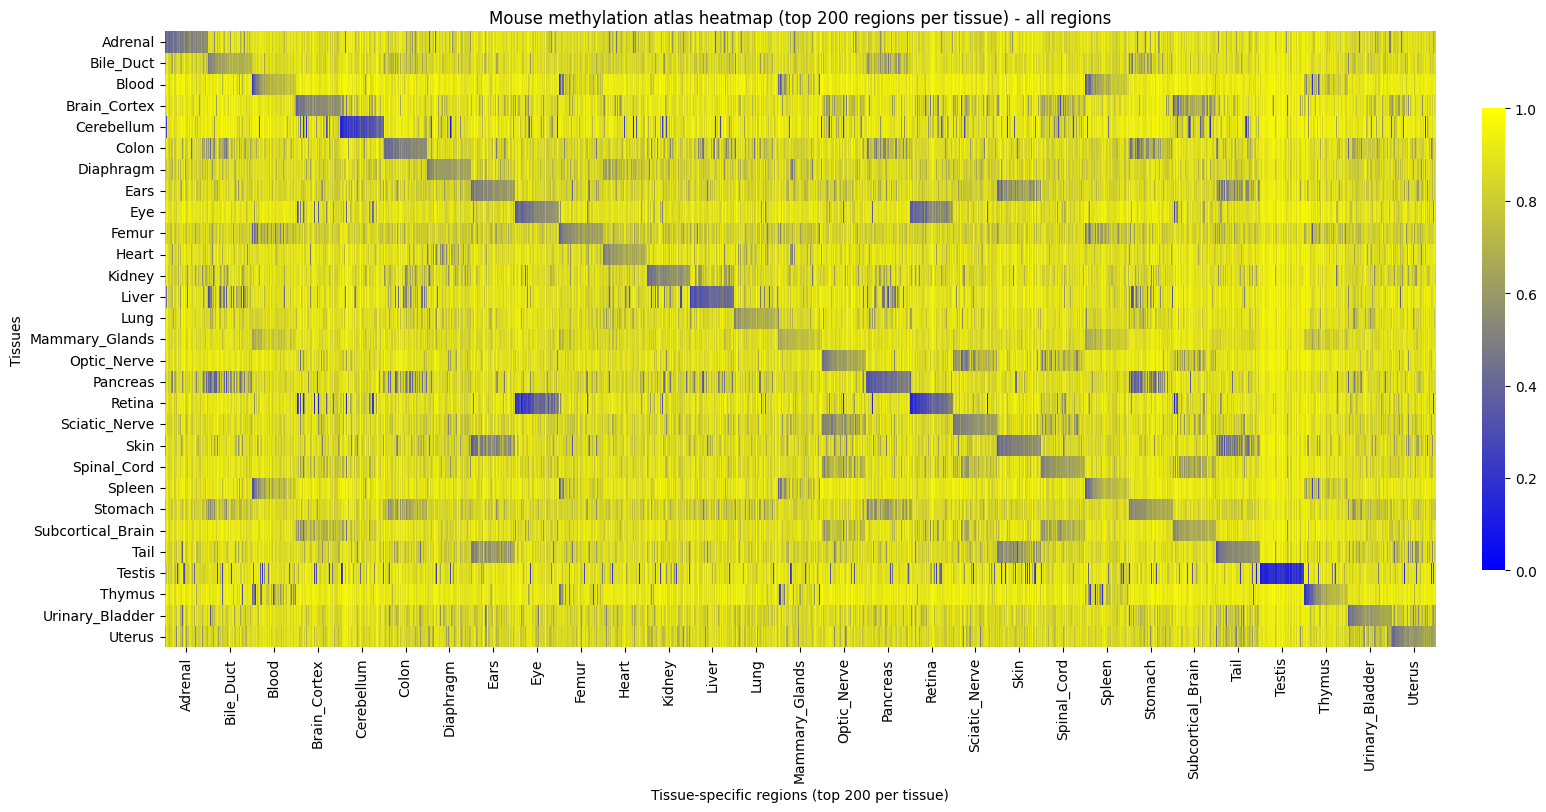

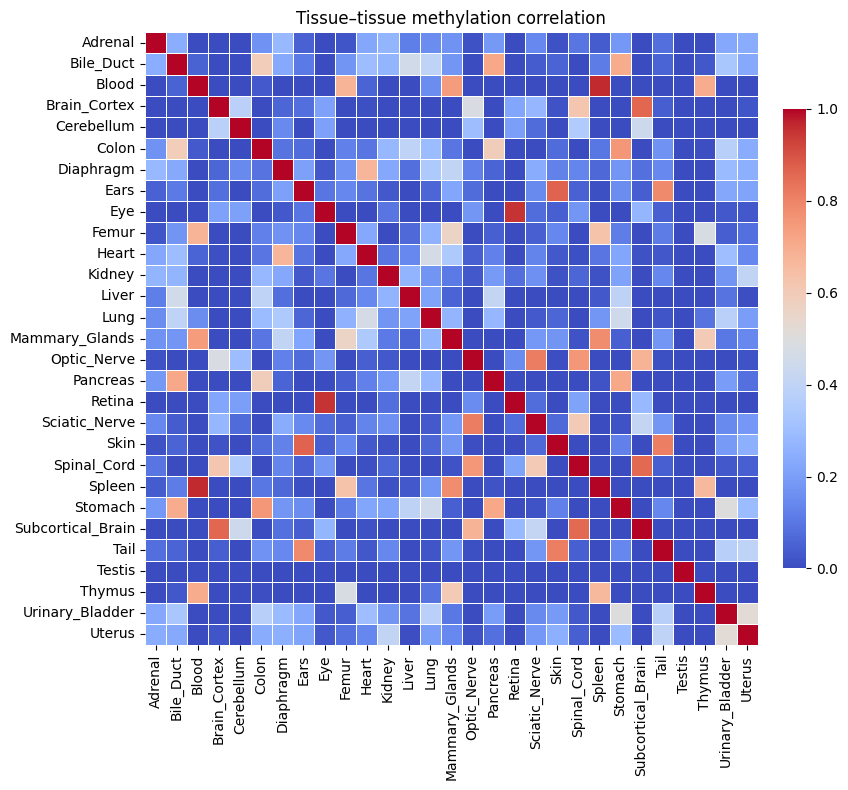

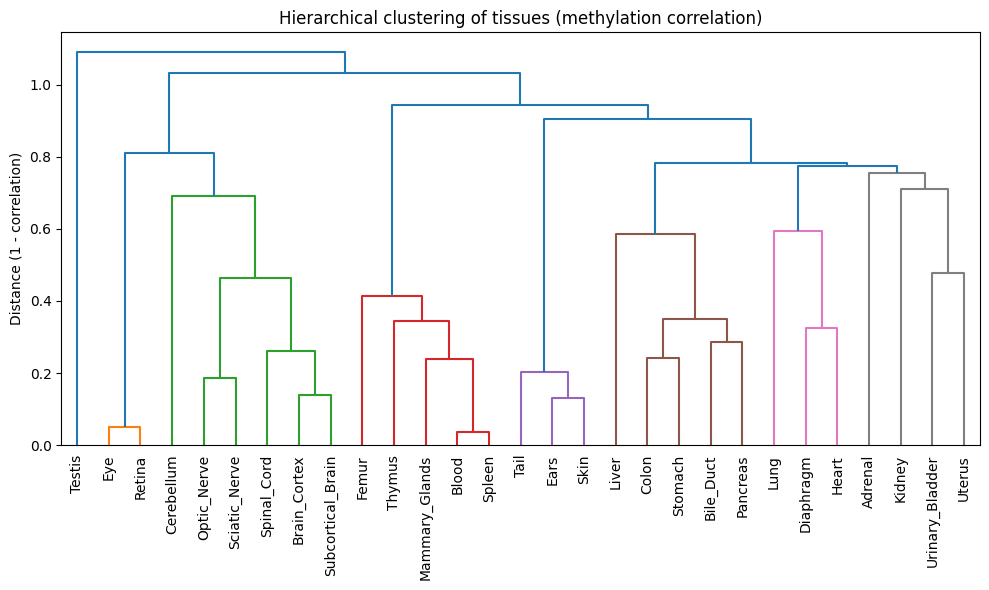

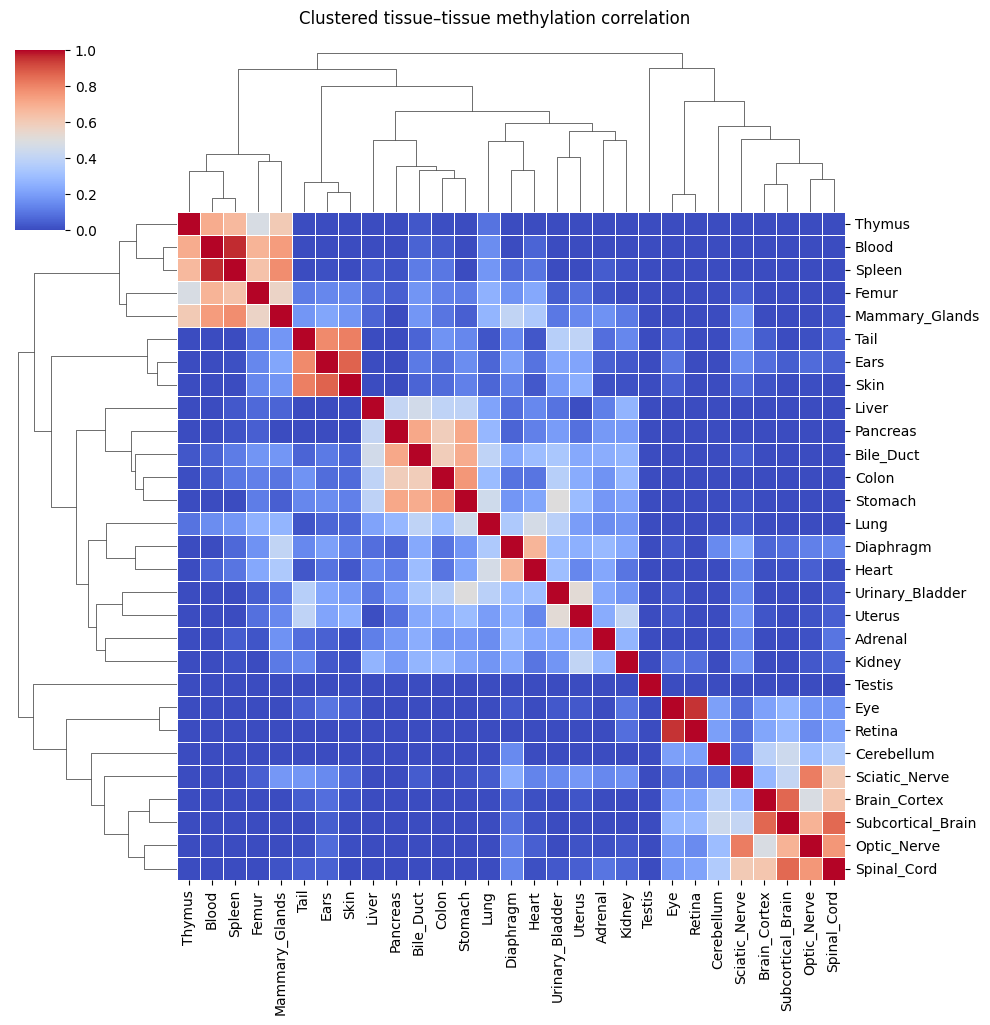

In [12]:
""" FULL PIPELINE - 29 TISSUES """

# Step 1: compute per-tissue differential tables
all_tissues_results = build_tissue_diff_table(
    df=DATAFRAME,
    use_filtering=USE_FILTERING
)

# Step 2: extract top N regions per tissue
df_top_regions = extract_top_regions(
    all_tissues_results,
    top_n=TOP_N
)

# Step 3: create heatmap matrix (tissues × regions)
heatmap_matrix, regions_per_tissue_count = create_heatmap_matrix(
    df=DATAFRAME,
    df_top_regions=df_top_regions,
    region_mode=REGION_MODE,
    max_per_tissue=MAX_PER_TISSUE, # <--- will raise warning if not None (if in combination with region_mode="all")
    verbose=USE_VERBOSE
)

# Step 4: plot methylation heatmap
plot_heatmap(
    heatmap_matrix,
    regions_per_tissue_count,
    top_n=TOP_N,
    title=f"{HEATMAP_TITLE} (top {TOP_N} regions per tissue) - {REGION_MODE} regions"
)

# Step 5: compute tissue–tissue correlation matrix
tissue_corr = compute_tissue_correlation(
    heatmap_matrix,
    method=CORR_METHOD
)

# Step 6: plot tissue correlation heatmap
plot_tissue_correlation(
    tissue_corr,
    title=CORR_TITLE
)

# Step 7: plot tissue dendrogram (hierarchical clustering)
Z = plot_tissue_dendrogram(
    tissue_corr,
    method=CLUSTER_METHOD,
    title=DENDRO_TITLE
)

# Step 8: plot clustered tissue correlation heatmap
plot_clustered_tissue_correlation(
    tissue_corr,
    title=CLUSTERED_CORR_TITLE
)


In [13]:
""" PIPELINE CONFIG 20 Tissues"""

# input dataframe
DATAFRAME = df_merged            # tissue-averaged beta matrix (probe_ID + tissues)

# use filtering + diff ranking (True) VS. Only diff ranking (False)
USE_FILTERING = True               # passed to build_tissue_diff_table
USE_VERBOSE = True                 # display the distribution of regions in cell types.
MAX_PER_TISSUE = 50

# region selection
TOP_N = 200                        # number of top regions per tissue
REGION_MODE = "unique"                # "all" or "unique"

# correlation / clustering
CORR_METHOD = "pearson"            # "pearson" or "spearman"
CLUSTER_METHOD = "average"         # linkage method

# plotting
HEATMAP_TITLE = "Mouse methylation atlas heatmap"
CORR_TITLE = "Tissue–tissue methylation correlation"
DENDRO_TITLE = "Hierarchical clustering of tissues (methylation correlation)"
CLUSTERED_CORR_TITLE = "Clustered tissue–tissue methylation correlation"

Top regions shape: (4000, 5)
Region mode: unique

--- BEFORE capping (max_per_tissue=50) ---
Total regions: 20


n_regions
tissue                             
Adrenal                         157
Bile_Duct                        90
Blood_Spleen_Thymus             110
Brain_Cortex_Subcortical         99
Cerebellum                      140
Colon                           118
Diaphragm                       129
Eye_Retina                      154
Femur                           104
Heart                           112
Kidney                          137
Liver                           141
Lung                            118
Pancreas                         77
Skin_Ears_Tail                  137
Spinal_Cord                     115
Stomach                          80
Testis                          188
Urinary_Bladder                 109
Uterus                          115


--- AFTER capping ---
Total regions: 1000


n_regions
tissue                             
Eye_Retina                       50
Brain_Cortex_Subcortical         50
Blood_Spleen_Thymus              50
Skin_Ears_Tail                   50
Adrenal                          50
Bile_Duct                        50
Cerebellum                       50
Colon                            50
Diaphragm                        50
Femur                            50
Heart                            50
Kidney                           50
Liver                            50
Lung                             50
Pancreas                         50
Spinal_Cord                      50
Stomach                          50
Testis                           50
Urinary_Bladder                  50
Uterus                           50

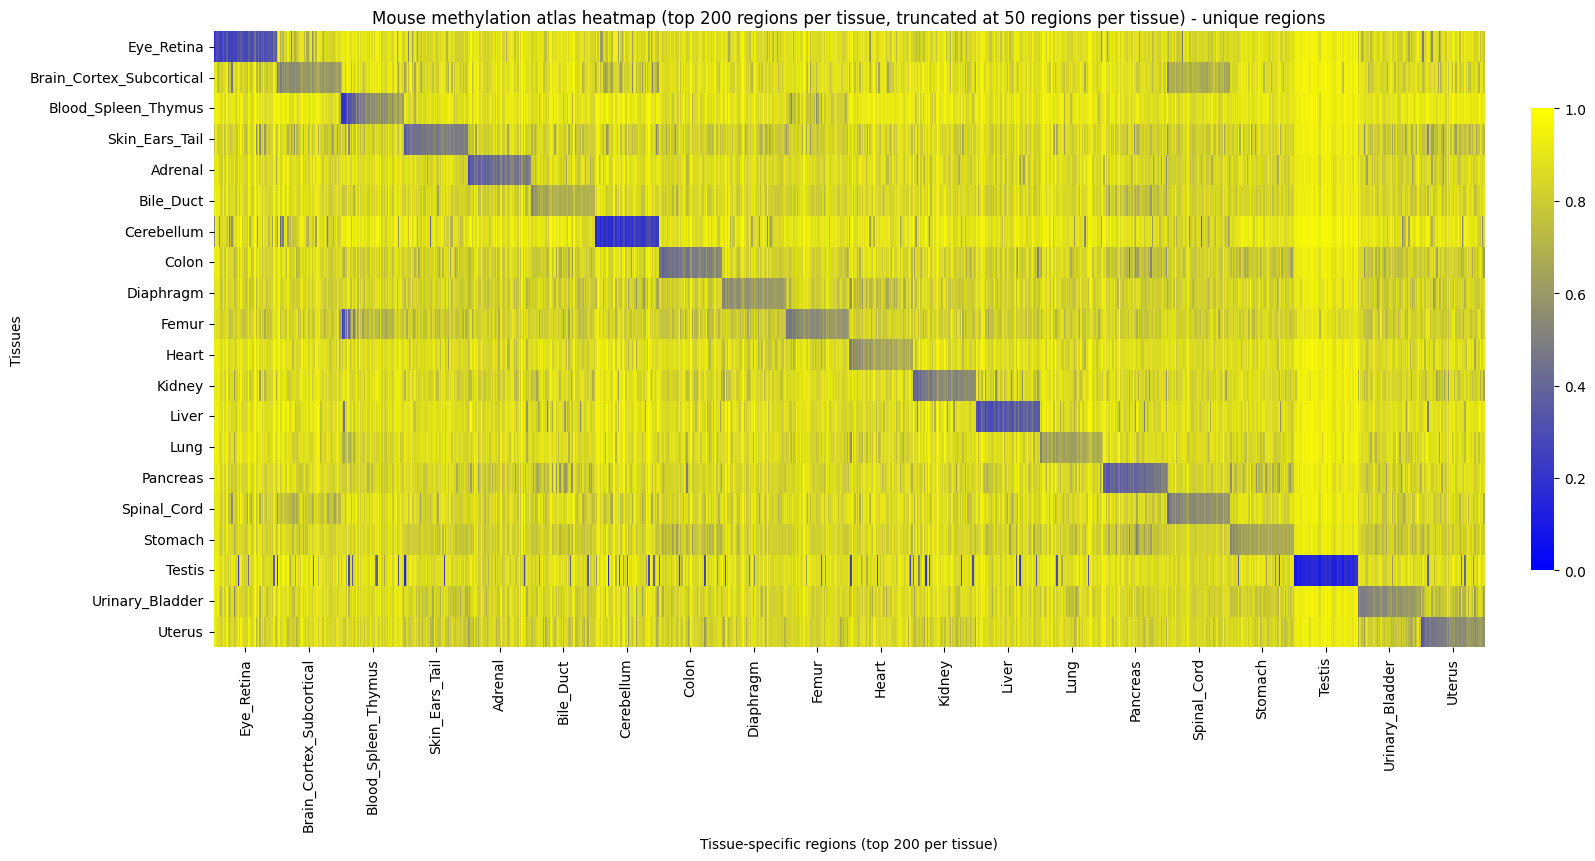

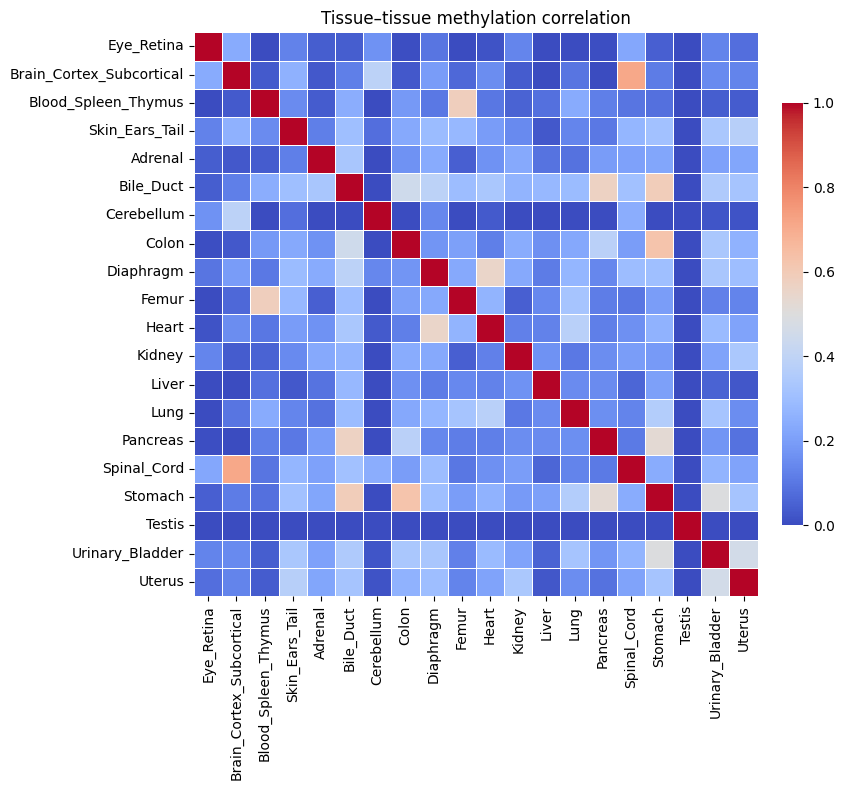

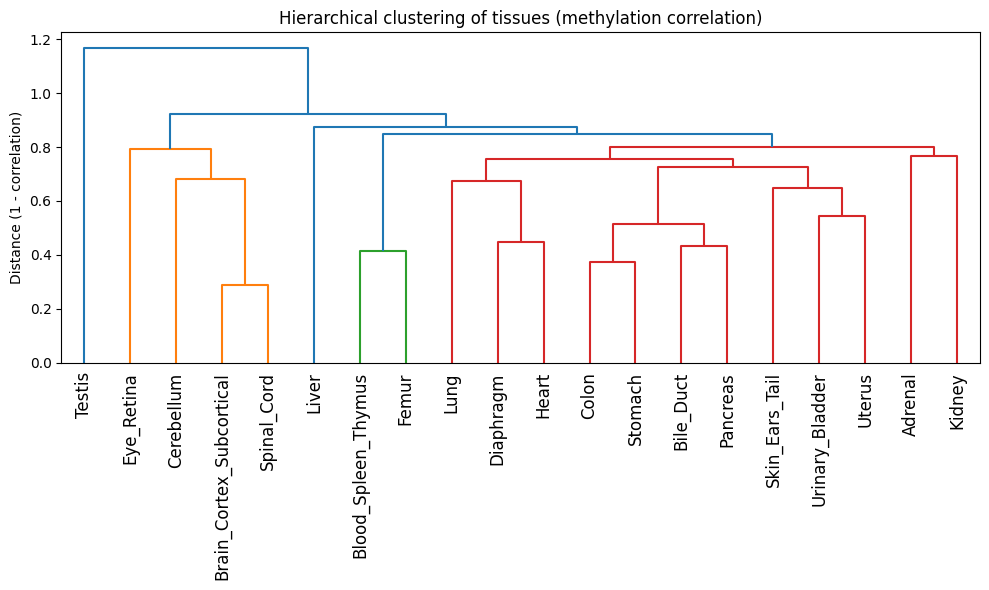

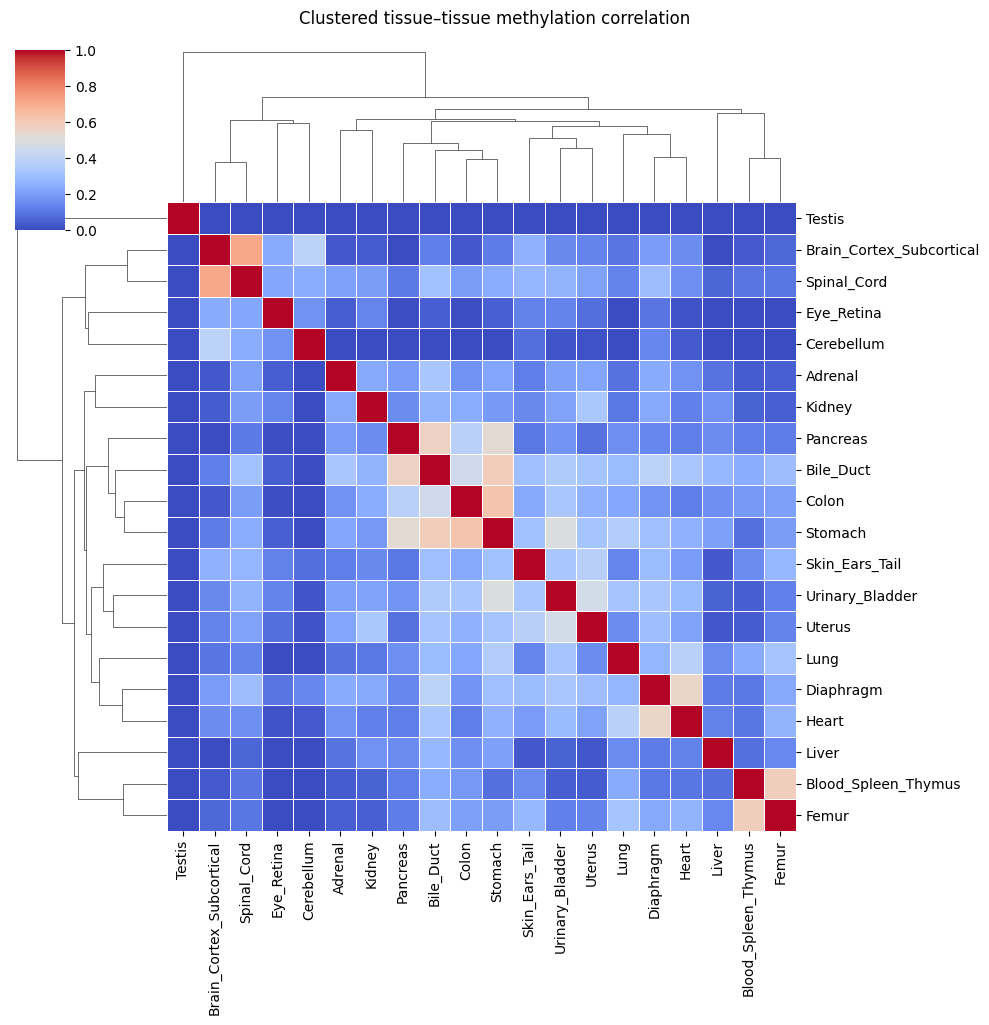

In [14]:
""" FULL PIPELINE - 21 TISSUES """

# Step 1: compute per-tissue differential tables
all_tissues_results = build_tissue_diff_table(
    df=DATAFRAME,
    use_filtering=USE_FILTERING
)

# Step 2: extract top N regions per tissue
df_top_regions = extract_top_regions(
    all_tissues_results,
    top_n=TOP_N
)

# Step 3: create heatmap matrix (tissues × regions)
heatmap_matrix, regions_per_tissue_count = create_heatmap_matrix(
    df=DATAFRAME,
    df_top_regions=df_top_regions,
    region_mode=REGION_MODE,
    max_per_tissue=MAX_PER_TISSUE,
    verbose=USE_VERBOSE
)

# Step 4: plot methylation heatmap
plot_heatmap(
    heatmap_matrix,
    regions_per_tissue_count,
    top_n=TOP_N,
    title=f"{HEATMAP_TITLE} (top {TOP_N} regions per tissue, truncated at {MAX_PER_TISSUE} regions per tissue) - {REGION_MODE} regions"
)

# Step 5: compute tissue–tissue correlation matrix
tissue_corr = compute_tissue_correlation(
    heatmap_matrix,
    method=CORR_METHOD
)

# Step 6: plot tissue correlation heatmap
plot_tissue_correlation(
    tissue_corr,
    title=CORR_TITLE
)

# Step 7: plot tissue dendrogram (hierarchical clustering)
Z = plot_tissue_dendrogram(
    tissue_corr,
    method=CLUSTER_METHOD,
    title=DENDRO_TITLE
)

# Step 8: plot clustered tissue correlation heatmap
plot_clustered_tissue_correlation(
    tissue_corr,
    title=CLUSTERED_CORR_TITLE
)


Top regions shape: (4000, 5)
Region mode: unique

--- BEFORE capping (max_per_tissue=50) ---
Total regions: 20


n_regions
tissue                             
Adrenal                         186
Bile_Duct                       153
Blood_Spleen_Thymus             108
Brain_Cortex_Subcortical        118
Cerebellum                      174
Colon                           167
Diaphragm                       170
Eye_Retina                      185
Femur                           106
Heart                           163
Kidney                          176
Liver                           187
Lung                            168
Pancreas                        159
Skin_Ears_Tail                  186
Spinal_Cord                     134
Stomach                         152
Testis                          196
Urinary_Bladder                 170
Uterus                          168


--- AFTER capping ---
Total regions: 1000


n_regions
tissue                             
Eye_Retina                       50
Brain_Cortex_Subcortical         50
Blood_Spleen_Thymus              50
Skin_Ears_Tail                   50
Adrenal                          50
Bile_Duct                        50
Cerebellum                       50
Colon                            50
Diaphragm                        50
Femur                            50
Heart                            50
Kidney                           50
Liver                            50
Lung                             50
Pancreas                         50
Spinal_Cord                      50
Stomach                          50
Testis                           50
Urinary_Bladder                  50
Uterus                           50

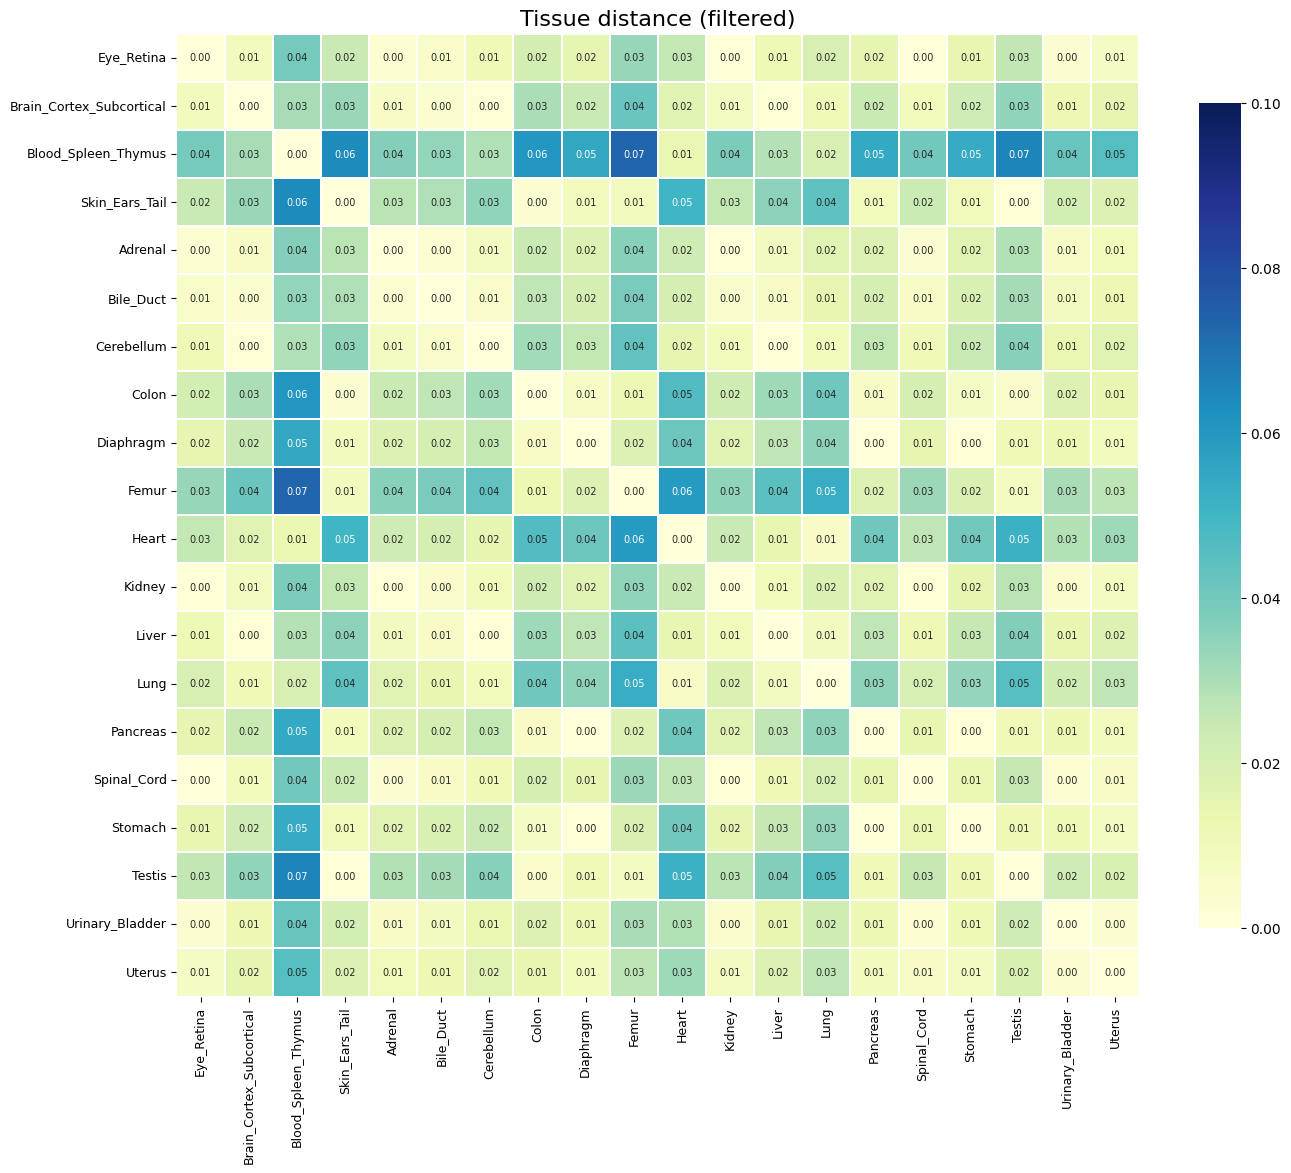

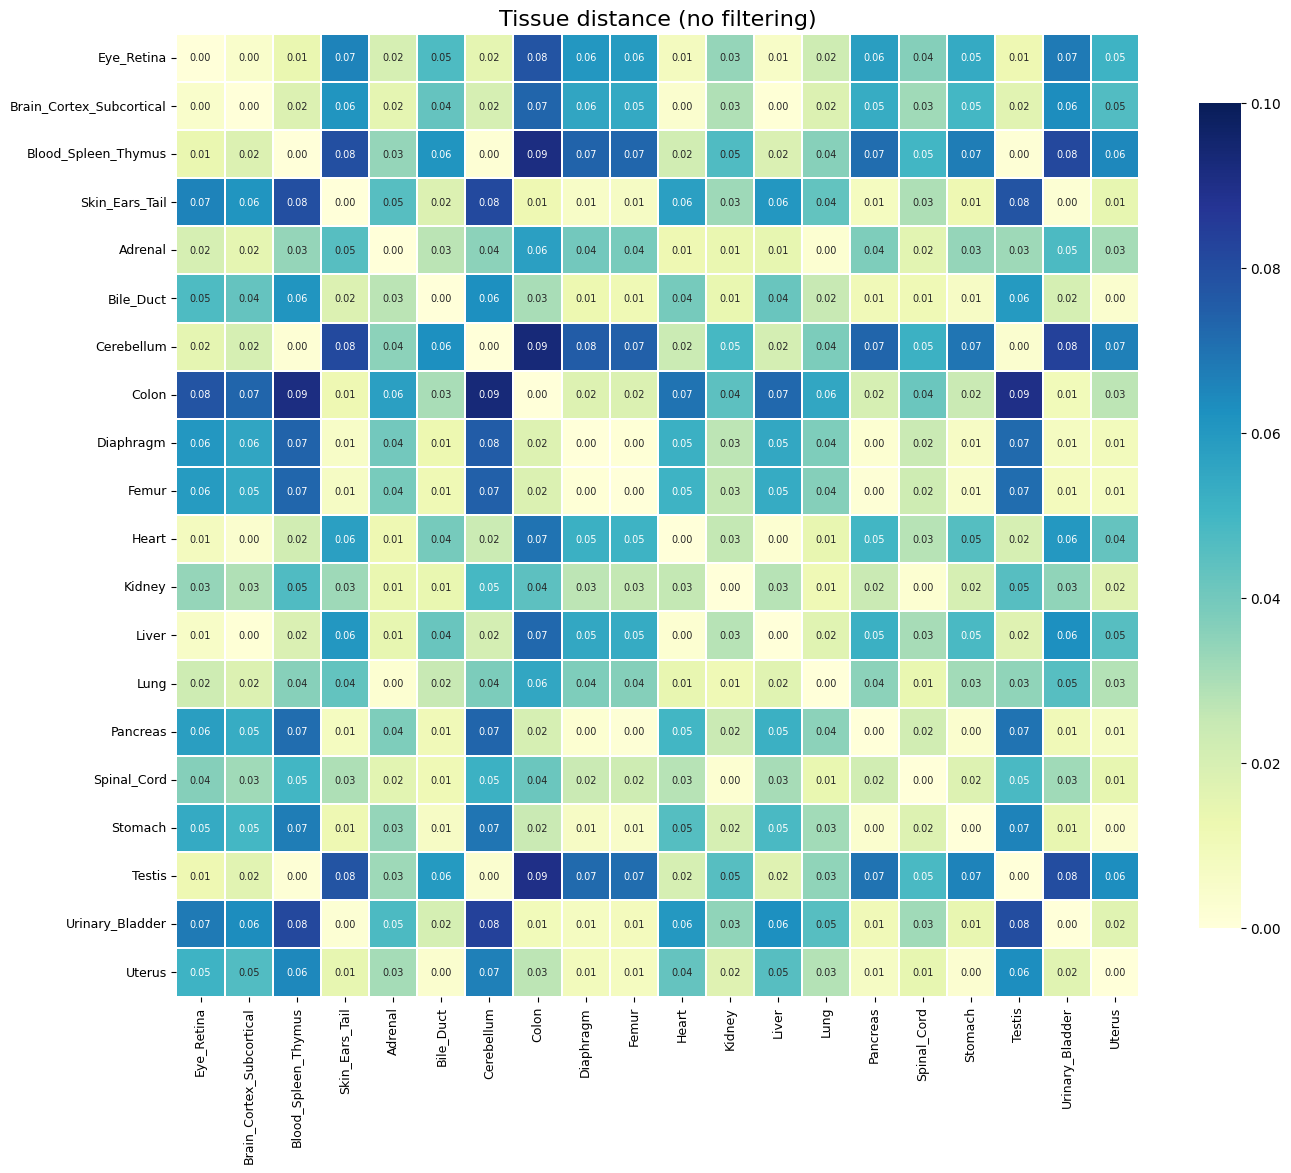

In [15]:
"""
Compute Pairwise Distance Matrices for heatmap_matrix (USE_FILTERING == True) and heatmap_matrix_no_filtering (USE_FILTERING == False).
NB! In current state (as of 03/02/2026), the matrices have different dimensions -> Direct comparison between two matrices are not really compatible feature-wise, and might instead show some feature selection effects.
As of 11/02/2026, this has been fixed!
"""
# Step 1: compute per-tissue differential tables
all_tissues_results_no_filtering = build_tissue_diff_table(
    df=DATAFRAME,
    use_filtering=False
)

# Step 2: extract top N regions per tissue
df_top_regions_no_filtering = extract_top_regions(
    all_tissues_results_no_filtering,
    top_n=TOP_N
)

# Step 3: create heatmap matrix (tissues × regions)
heatmap_matrix_no_filtering,_ = create_heatmap_matrix(
    df=DATAFRAME,
    df_top_regions=df_top_regions_no_filtering,
    region_mode=REGION_MODE,
    max_per_tissue=MAX_PER_TISSUE,
    verbose=USE_VERBOSE
)

#average over regions (columns) -> one value per tissue

heatmap_matrix_avg = heatmap_matrix.mean(axis=1)
heatmap_matrix_no_filtering_avg = heatmap_matrix_no_filtering.mean(axis=1)

# sanity check
assert (heatmap_matrix_avg.index == heatmap_matrix_no_filtering_avg.index).all()

tissues = heatmap_matrix_avg.index

# compute pairwise tissue–tissue distance matrices

# make them into column vectors (needed for scipy)
X = heatmap_matrix_avg.values.reshape(-1, 1)
X_nf = heatmap_matrix_no_filtering_avg.values.reshape(-1, 1)

dist_mat = squareform(pdist(X, metric="euclidean"))
dist_mat_no_filtering = squareform(pdist(X_nf, metric="euclidean"))

dist_df = pd.DataFrame(dist_mat, index=tissues, columns=tissues)
dist_df_no_filtering = pd.DataFrame(
    dist_mat_no_filtering, index=tissues, columns=tissues
)
# plot 1: filtered

plt.figure(figsize=(14, 12))
sns.heatmap(
    dist_df,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    vmin=0,
    vmax=0.1
)
plt.title("Tissue distance (filtered)", fontsize=16)
plt.xticks(fontsize=9, rotation=90)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# plot 2: no filtering

plt.figure(figsize=(14, 12))
sns.heatmap(
    dist_df_no_filtering,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    vmin=0,
    vmax=0.1 
)
plt.title("Tissue distance (no filtering)", fontsize=16)
plt.xticks(fontsize=9, rotation=90)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


In [16]:
# --------------------------------------------- Orthogonal distances validation (PCA)--------------------------------------------------
print(heatmap_matrix.shape)

display(
    HTML(
        heatmap_matrix
        .to_html(max_rows=None)
        .replace(
            '<table border="1" class="dataframe">',
            '<table border="1" class="dataframe" style="height:600px; overflow-y:scroll; display:block;">'
        )
    )
)


(20, 1000)


In [17]:
"""
PCA QC Check - Do my extracted regions in heatmap_matrix encode useful information?
"""

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# convert df to numpy array
X = heatmap_matrix.values
#extract tissues
tissues = heatmap_matrix.index

# try both with scaled and not scaled. We center in both cases.
# X_centered = StandardScaler(with_std=False).fit_transform(X)
X_scaled = StandardScaler(with_std=True).fit_transform(X)


pca = PCA(n_components=10)
#X_pca_centered = pca.fit_transform(X_centered)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

print("Explained variance (first 10 PCs):")
for i in range(10):
    print(f"PC{i+1}: {explained[i]*100:.1f}%")

print("\nCumulative variance (first 10 PCs):")
for i in range(10):
    print(f"PC1–PC{i+1}: {cumulative[i]*100:.1f}%")


Explained variance (first 10 PCs):
PC1: 14.2%
PC2: 11.1%
PC3: 8.3%
PC4: 7.8%
PC5: 6.8%
PC6: 6.3%
PC7: 5.9%
PC8: 5.4%
PC9: 5.1%
PC10: 5.0%

Cumulative variance (first 10 PCs):
PC1–PC1: 14.2%
PC1–PC2: 25.3%
PC1–PC3: 33.7%
PC1–PC4: 41.4%
PC1–PC5: 48.2%
PC1–PC6: 54.5%
PC1–PC7: 60.4%
PC1–PC8: 65.7%
PC1–PC9: 70.8%
PC1–PC10: 75.8%


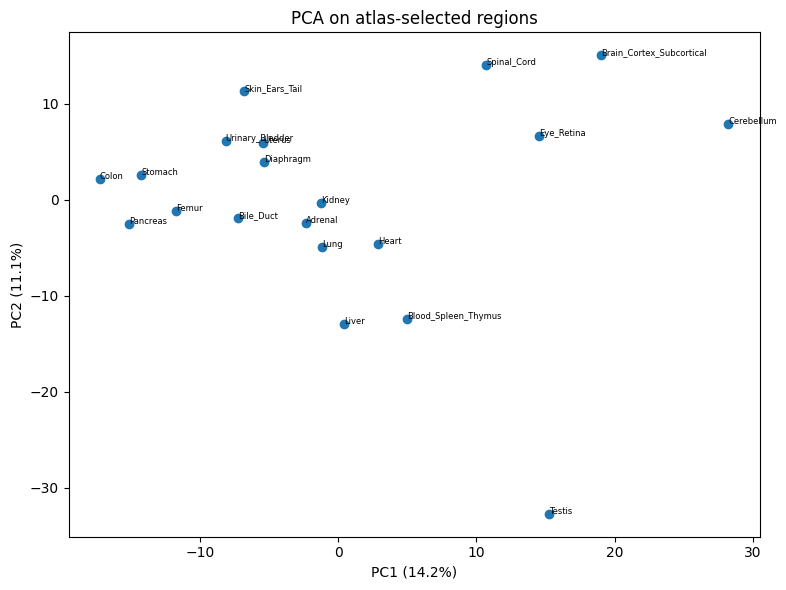

In [18]:
# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

for i, t in enumerate(tissues):
    plt.text(X_pca[i, 0], X_pca[i, 1], t, fontsize=6)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA on atlas-selected regions")
plt.tight_layout()
plt.show()

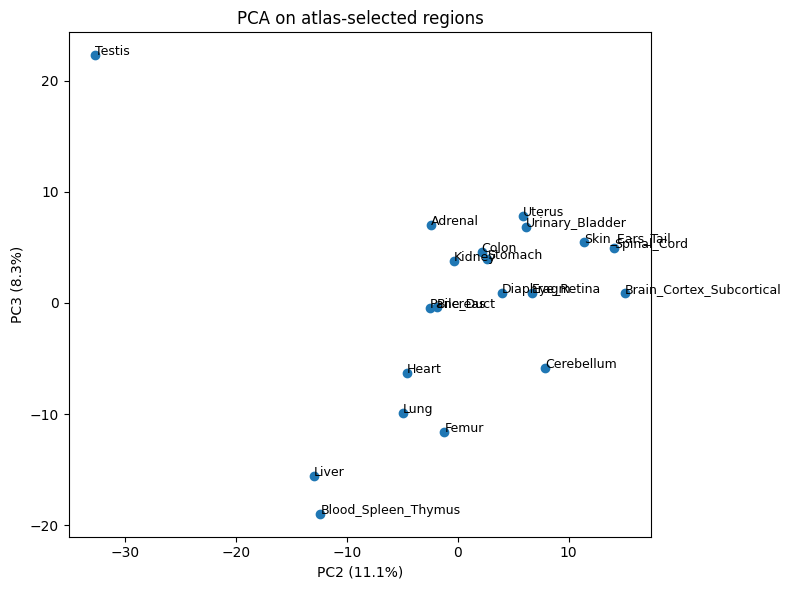

In [19]:
# plot PC2 vs PC3
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 1], X_pca[:, 2])

for i, t in enumerate(tissues):
    plt.text(X_pca[i, 1], X_pca[i, 2], t, fontsize=9)

plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
plt.title("PCA on atlas-selected regions")
plt.tight_layout()
plt.show()

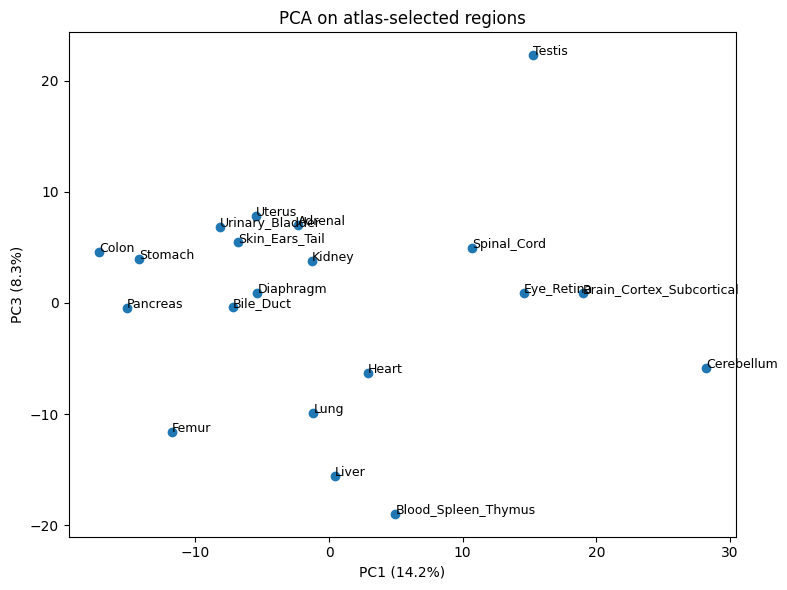

In [20]:
# plot PC1 vs PC3
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 2])

for i, t in enumerate(tissues):
    plt.text(X_pca[i, 0], X_pca[i, 2], t, fontsize=9)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
plt.title("PCA on atlas-selected regions")
plt.tight_layout()
plt.show()

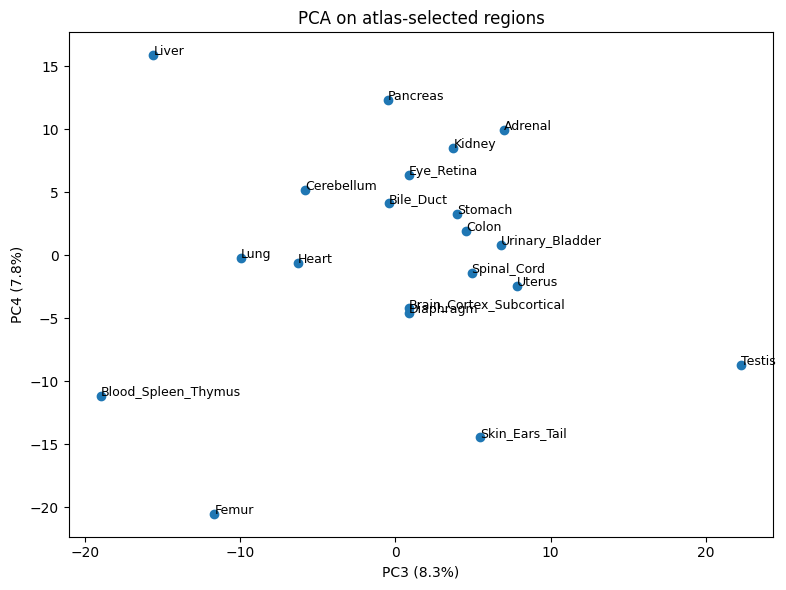

In [21]:
# plot PC3 vs PC4
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 2], X_pca[:, 3])

for i, t in enumerate(tissues):
    plt.text(X_pca[i, 2], X_pca[i, 3], t, fontsize=9)

plt.xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
plt.ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)")
plt.title("PCA on atlas-selected regions")
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import plotly.express as px

df_pca = pd.DataFrame(
    X_pca[:, :3],
    columns=["PC1", "PC2", "PC3"],
    index=tissues
).reset_index(names="tissue")

fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    #hover_name="tissue",
    text="tissue",
    title="3D PCA of atlas tissues"
)

fig.update_traces(
    marker=dict(size=4, opacity=0.7),
    textfont=dict(size=9),
    textposition="top center"
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        zaxis_title=f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [23]:
"""
TEST: Remove testis to see if it was dominating PC1 - if it was "testis vs all"
"""
# remove testis - only diagnostic
heatmap_matrix_no_testis = heatmap_matrix.drop(index="Testis")

print("Original shape:", heatmap_matrix.shape)
print("No Testis shape:", heatmap_matrix_no_testis.shape)


X_no_testis = heatmap_matrix_no_testis.values
tissues_no_testis = heatmap_matrix_no_testis.index


X_no_testis = StandardScaler().fit_transform(X_no_testis)

pca_no_testis = PCA()
X_pca_no_testis = pca_no_testis.fit_transform(X_no_testis)


explained = pca_no_testis.explained_variance_ratio_
cumulative = np.cumsum(explained)

print("Explained variance (first 10 PCs):")
for i in range(10):
    print(f"PC{i+1}: {explained[i]*100:.1f}%")

print("\nCumulative variance (first 10 PCs):")
for i in range(10):
    print(f"PC1–PC{i+1}: {cumulative[i]*100:.1f}%")


Original shape: (20, 1000)
No Testis shape: (19, 1000)
Explained variance (first 10 PCs):
PC1: 16.4%
PC2: 10.2%
PC3: 8.8%
PC4: 7.4%
PC5: 6.9%
PC6: 6.4%
PC7: 5.9%
PC8: 5.6%
PC9: 5.4%
PC10: 4.7%

Cumulative variance (first 10 PCs):
PC1–PC1: 16.4%
PC1–PC2: 26.6%
PC1–PC3: 35.4%
PC1–PC4: 42.8%
PC1–PC5: 49.7%
PC1–PC6: 56.1%
PC1–PC7: 62.0%
PC1–PC8: 67.6%
PC1–PC9: 73.0%
PC1–PC10: 77.7%


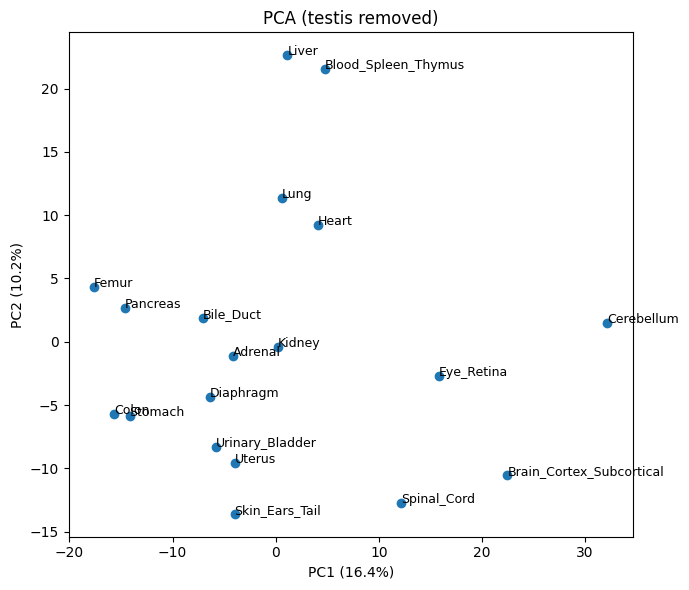

In [24]:
# No testis PC1 vs PC2
plt.figure(figsize=(7, 6))
plt.scatter(X_pca_no_testis[:, 0], X_pca_no_testis[:, 1])

for i, t in enumerate(tissues_no_testis):
    plt.text(X_pca_no_testis[i, 0], X_pca_no_testis[i, 1], t, fontsize=9)

plt.xlabel(f"PC1 ({explained[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}%)")
plt.title("PCA (testis removed)")
plt.tight_layout()
plt.show()


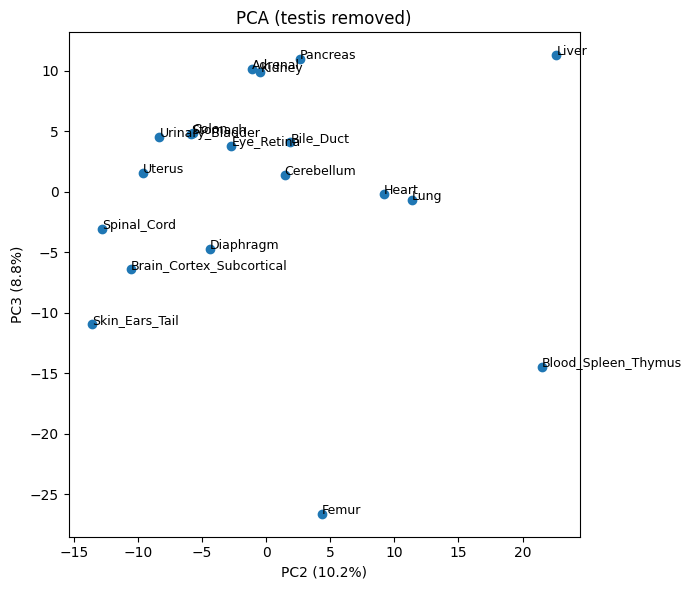

In [25]:
# No testis PC2 vs PC3
plt.figure(figsize=(7, 6))
plt.scatter(X_pca_no_testis[:, 1], X_pca_no_testis[:, 2])

for i, t in enumerate(tissues_no_testis):
    plt.text(X_pca_no_testis[i, 1], X_pca_no_testis[i, 2], t, fontsize=9)

plt.xlabel(f"PC2 ({explained[1]*100:.1f}%)")
plt.ylabel(f"PC3 ({explained[2]*100:.1f}%)")
plt.title("PCA (testis removed)")
plt.tight_layout()
plt.show()


In [26]:
""" FULL PIPELINE - 21 TISSUES """

# Step 1: compute per-tissue differential tables
all_tissues_results = build_tissue_diff_table(
    df=DATAFRAME,
    use_filtering=USE_FILTERING
)

# Step 2: extract top N regions per tissue
df_top_regions = extract_top_regions(
    all_tissues_results,
    top_n=TOP_N
)


df_top_regions.shape

df_top_regions["probe_ID"].nunique()

# # Step 3: create heatmap matrix (tissues × regions)
# heatmap_matrix, regions_per_tissue_count = create_heatmap_matrix(
#     df=DATAFRAME,
#     df_top_regions=df_top_regions,
#     region_mode=REGION_MODE,
#     max_per_tissue=MAX_PER_TISSUE,
#     verbose=USE_VERBOSE
# )

Top regions shape: (4000, 5)


3117

In [27]:
list_probes = heatmap_matrix.columns.to_list()
list_probes_set = set(list_probes)

mask = df_top_regions[df_top_regions["probe_ID"].isin(list_probes_set)]
mask.nunique()

probe_ID           1000
tissue               20
target_meth         964
background_meth    1000
diff               1000
dtype: int64

In [ ]:
"""claude code cooking"""
def build_annotated_regions(
    heatmap_matrix: pd.DataFrame,
    df_top_regions: pd.DataFrame,
    df_annot: pd.DataFrame,
    probe_col: str = "probe_ID",
    annot_probe_col: str = "Probe_ID",
) -> pd.DataFrame:
    """
    Join the probes that survived into heatmap_matrix with their differential
    stats (from df_top_regions) and genomic metadata (from df_annot).

    The join uses BOTH probe_ID AND tissue so that we only pull the row that
    was actually responsible for a probe being selected — not other tissues
    that probe may have ranked for.

    Parameters
    ----------
    heatmap_matrix : pd.DataFrame
        Tissues × regions matrix returned by create_heatmap_matrix().
        Columns are probe IDs; index is tissue names.
    df_top_regions : pd.DataFrame
        Long-format table with columns: probe_ID, tissue, target_meth,
        background_meth, diff.  Returned by extract_top_regions().
    df_annot : pd.DataFrame
        Annotation file with at minimum a Probe_ID column and genomic
        metadata columns (CpG_chrm, CpG_beg, CpG_end, gene name, etc.).
    probe_col : str
        Column name in df_top_regions that holds probe IDs.
    annot_probe_col : str
        Column name in df_annot that holds probe IDs.

    Returns
    -------
    pd.DataFrame
        Long-format annotated table sorted by tissue then diff (descending).
        Columns: tissue, probe_ID, target_meth, background_meth, diff,
                 + all annotation columns.
    """
    # probes present in heatmap_matrix (order preserved: left-to-right = region order)
    selected_probes = heatmap_matrix.columns.tolist()
    selected_probe_set = set(selected_probes)

    # For each probe in heatmap_matrix we need to know WHICH tissue it was
    # selected for.  create_heatmap_matrix preserves the order produced by
    # extract_top_regions / groupby("tissue").head(max_per_tissue), so we can
    # reconstruct the tissue assignment by taking, for every probe that is in
    # selected_probe_set, the FIRST occurrence in df_top_regions (which
    # corresponds to the tissue that ranked it highest after uniqueness filtering).
    probe_to_tissue = (
        df_top_regions[df_top_regions[probe_col].isin(selected_probe_set)]
        .drop_duplicates(subset=probe_col, keep="first")
        [[probe_col, "tissue"]]
    )

    # pull the full stats row for each (probe, tissue) pair
    df_stats = df_top_regions.merge(
        probe_to_tissue,
        on=[probe_col, "tissue"],
        how="inner",
    )

    #merge with annotation
    df_annotated = df_stats.merge(
        df_annot,
        left_on=probe_col,
        right_on=annot_probe_col,
        how="left",
    )

    # drop duplicate probe column if annot uses a different name
    if annot_probe_col != probe_col and annot_probe_col in df_annotated.columns:
        df_annotated = df_annotated.drop(columns=[annot_probe_col])

    # sort: tissue alphabetically, then best-scoring probes first
    df_annotated = df_annotated.sort_values(
        ["tissue", "diff"], ascending=[True, False]
    ).reset_index(drop=True)

    print(f"Annotated regions shape: {df_annotated.shape}")
    print(f"Tissues represented: {df_annotated['tissue'].nunique()}")
    print(f"Unique probes: {df_annotated[probe_col].nunique()}")

    return df_annotated

In [29]:
df_annot_final = build_annotated_regions(heatmap_matrix=heatmap_matrix, df_top_regions=df_top_regions, df_annot= df_annot)


display(
    HTML(
        df_annot_final
        .to_html(max_rows=None)
        .replace(
            '<table border="1" class="dataframe">',
            '<table border="1" class="dataframe" style="height:600px; overflow-y:scroll; display:block;">'
        )
    )
)


Annotated regions shape: (1000, 33)
Tissues represented: 20
Unique probes: 1000


In [ ]:
def export_annotated_regions_excel(
    df_annotated: pd.DataFrame,
    output_path: Path,
    probe_col: str = "probe_ID",
) -> None:
    """
    Write df_annotated to a formatted Excel workbook (single sheet).

    Formatting:
    - Frozen header row with bold column names
    - Tissue column uses alternating light-blue banding per tissue block
    - diff, target_meth, background_meth formatted to 4 decimal places
    - Auto-sized columns (capped at 40)
    - A separate summary sheet with region counts per tissue
    """
    wb = openpyxl.Workbook()

    # ---- Sheet 1: All regions -----------------------------------------------
    ws = wb.active
    ws.title = "Annotated Regions"

    cols = df_annotated.columns.tolist()

    # Header
    header_fill = PatternFill("solid", fgColor="1F4E79")
    header_font = Font(name="Arial", bold=True, color="FFFFFF", size=10)
    center = Alignment(horizontal="center", vertical="center")
    thin = Side(style="thin", color="BFBFBF")
    border = Border(bottom=thin)

    for ci, col in enumerate(cols, start=1):
        cell = ws.cell(row=1, column=ci, value=col)
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = center
        cell.border = border

    ws.freeze_panes = "A2"
    ws.row_dimensions[1].height = 22

    # alternate band colours per tissue block
    band_colours = ["DCE6F1", "EBF3FB"]   # light blue alternating shades
    normal_font = Font(name="Arial", size=10)
    number_fmt = "0.0000"

    metric_cols = {"target_meth", "background_meth", "diff"}

    tissue_order = df_annotated["tissue"].unique().tolist()
    tissue_band = {t: band_colours[i % 2] for i, t in enumerate(tissue_order)}

    for ri, row in enumerate(df_annotated.itertuples(index=False), start=2):
        tissue_val = getattr(row, "tissue")
        fill = PatternFill("solid", fgColor=tissue_band[tissue_val])

        for ci, col in enumerate(cols, start=1):
            val = getattr(row, col.replace(" ", "_"))
            cell = ws.cell(row=ri, column=ci, value=val)
            cell.font = normal_font
            cell.fill = fill
            if col in metric_cols:
                cell.number_format = number_fmt

    # auto-size columns
    for ci, col in enumerate(cols, start=1):
        max_len = max(
            len(str(col)),
            df_annotated[col].astype(str).str.len().max(),
        )
        ws.column_dimensions[get_column_letter(ci)].width = min(max_len + 2, 40)

    # ---- Sheet 2: Summary -------------------------------------------------
    ws_sum = wb.create_sheet("Region Counts")
    ws_sum.append(["Tissue", "N Regions", "Mean Diff", "Mean Target Meth", "Mean Background Meth"])

    sum_header_fill = PatternFill("solid", fgColor="375623")
    for cell in ws_sum[1]:
        cell.font = Font(name="Arial", bold=True, color="FFFFFF", size=10)
        cell.fill = sum_header_fill
        cell.alignment = center

    summary = (
        df_annotated
        .groupby("tissue", sort=True)
        .agg(
            n_regions=(probe_col, "count"),
            mean_diff=("diff", "mean"),
            mean_target=("target_meth", "mean"),
            mean_bg=("background_meth", "mean"),
        )
        .reset_index()
    )

    for row in summary.itertuples(index=False):
        ws_sum.append([row.tissue, row.n_regions, row.mean_diff, row.mean_target, row.mean_bg])

    for ci in range(1, 6):
        ws_sum.column_dimensions[get_column_letter(ci)].width = 22
        if ci > 1:
            for ri in range(2, ws_sum.max_row + 1):
                ws_sum.cell(row=ri, column=ci).number_format = "0.0000" if ci > 2 else "0"

    wb.save(output_path)
    print(f"Excel saved → {output_path}")

In [36]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

output_path = OUTPUT_DIR / "mouse_methylation_markers.xlsx"

print(output_path)
print(output_path.exists())


export_annotated_regions_excel(df_annotated=df_annot_final, output_path=output_path)




/home/jullid/projects/mouse-DNA-project/results/mouse_methylation_markers.xlsx
False
Excel saved → /home/jullid/projects/mouse-DNA-project/results/mouse_methylation_markers.xlsx


In [37]:
print(output_path)
print(output_path.exists())

/home/jullid/projects/mouse-DNA-project/results/mouse_methylation_markers.xlsx
True
